In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [2]:
train_df = pd.read_csv('arxiv_train.csv')
test_df = pd.read_csv('arxiv_test.csv')

In [3]:
train_df.dropna(subset=['abstract', 'label'], inplace=True)
test_df.dropna(subset=['abstract', 'label'], inplace=True)

In [4]:
import re

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = text.lower()
    return text

train_df['clean_abstract'] = train_df['abstract'].apply(clean_text)
test_df['clean_abstract'] = test_df['abstract'].apply(clean_text)


In [5]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])
num_classes = len(label_encoder.classes_)

In [6]:
# Tokenize the text
max_words = 10000  # Consider top 10,000 words
max_sequence_length = 100  # Truncate or pad abstracts to this length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['clean_abstract'])

# Convert text to sequences of indices
X_train_seq = tokenizer.texts_to_sequences(train_df['clean_abstract'])
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_abstract'])

In [7]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [8]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64),  # Reduced from 128
    Bidirectional(GRU(64, return_sequences=False)),  # Single RNN layer
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [9]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 130s 56ms/step - accuracy: 0.4718 - loss: 1.3949 - val_accuracy: 0.7624 - val_loss: 0.6744
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 120s 53ms/step - accuracy: 0.8067 - loss: 0.5703 - val_accuracy: 0.7903 - val_loss: 0.6035
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 133s 59ms/step - accuracy: 0.8496 - loss: 0.4404 - val_accuracy: 0.7974 - val_loss: 0.6018
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 128s 57ms/step - accuracy: 0.8822 - loss: 0.3492 - val_accuracy: 0.7834 - val_loss: 0.6603
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 131s 58ms/step - accuracy: 0.9103 - loss: 0.2734 - val_accuracy: 0.7811 - val_loss: 0.7262
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 163s 72ms/step - accuracy: 0.9348 - loss: 0.2007 - val_accuracy: 0.7793 - val_loss: 0.8264
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 127s 56ms/step - accuracy: 0.9539 - loss: 0.1438 - val_accuracy: 0.7765 - val_loss: 0.9602
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 121s 54ms/step - accuracy: 

In [12]:
test_loss, test_acc = model.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {test_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7575 - loss: 1.4606
Test accuracy: 0.7581


In [13]:
y_pred = np.argmax(model.predict(X_test_pad), axis=1)

# Calculate metrics
print("Classification Report:")
print(metrics.classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"Macro F1: {metrics.f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"Weighted F1: {metrics.f1_score(y_test, y_pred, average='weighted'):.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step
Classification Report:
              precision    recall  f1-score   support

    astro-ph       0.87      0.89      0.88      2013
    cond-mat       0.75      0.73      0.74      2058
          cs       0.65      0.58      0.62      1995
        eess       0.70      0.70      0.70      1948
      hep-ph       0.86      0.87      0.87      1990
      hep-th       0.86      0.82      0.84      2019
        math       0.79      0.82      0.80      2042
     physics       0.60      0.57      0.58      1977
    quant-ph       0.79      0.82      0.80      2013
        stat       0.70      0.77      0.73      1945

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Macro F1: 0.7562
Weighted F1: 0.7568


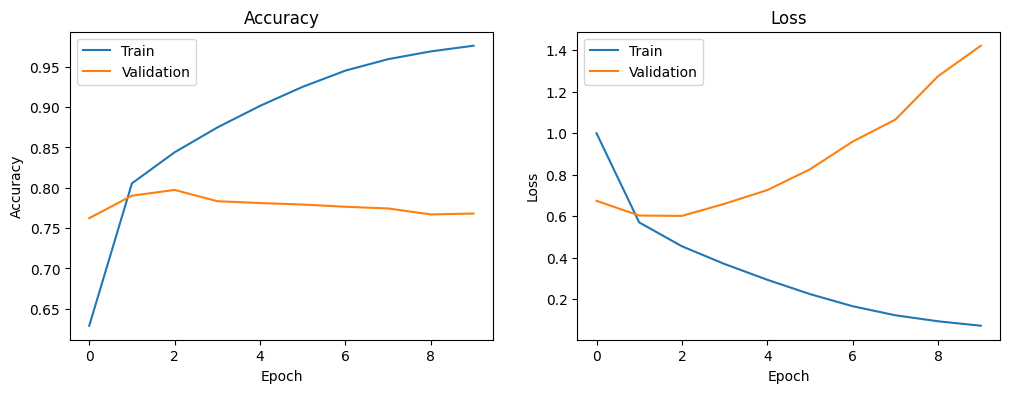

In [14]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()